### Парсинг данных и создание датафрейма

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

# %matplotlib notebook

In [2]:
runN = "*" # If take all runs set runN = "*"
paths = glob.glob(f"build/Run{runN}_nt_ParticleData_t*.csv")

In [ ]:
with open(paths[0], 'r') as f:
    print(f"Headers from file: {paths[0]}")
    
    lines = f.readline().strip()
    print(lines)
    columns = lines[1:]
    columns = columns.split(",")
    meta_len = 1

#     hlines = []
#     while True:
#         line = f.readline()
#         if len(line) == 0 or line[0] != '#':
#             break
#         hlines.append(line)
#     title = hlines[1].replace('#title ', '')[:-1]
#     sep = chr(int(hlines[2].replace('#separator ', '')[:-1]))
#     vsc_sep = chr(int(hlines[3].replace('#vector_separator ', '')[:-1]))
#     columns = [' '.join(l.split(' ')[2:])[:-1] for l in hlines[4:]]
#     meta_len = len(hlines)
#     print(f'Metarows: {meta_len}\nColumns: {columns}')

In [21]:
data = pd.DataFrame()
for path in paths:
    item = pd.read_csv(path, skiprows=meta_len, names=columns)
    data = data.append(item, ignore_index=True)

In [22]:
data

,particle_name,X,Y,Z,vX,vY,vZ,energy
0,gamma,112.9400,112.06400,15.947000,0.049367,0.047848,0.006458,0.069052
1,gamma,92.4699,101.41700,-82.048800,0.018160,0.020252,-0.016502,0.031816
2,gamma,-123.4870,101.57800,-0.888354,-0.099786,0.080022,-0.001552,0.127918
3,gamma,13.4741,130.48800,91.429400,0.008432,0.075131,0.052190,0.091867
4,gamma,-111.1900,-75.16960,-86.915400,-0.048676,-0.033796,-0.038917,0.070895
...,...,...,...,...,...,...,...,...
7384965,gamma,100.6970,-29.66280,-120.616000,0.056051,-0.016780,-0.067486,0.089318
7384966,gamma,-46.1179,-1.80092,-153.094000,-0.033838,-0.000539,-0.109349,0.114466
7384967,gamma,-13.9264,-83.09570,-135.901000,-0.010799,-0.056220,-0.093124,0.109313
7384968,gamma,-86.6186,121.24100,-58.016000,-0.019316,0.026093,-0.012785,0.034891


In [23]:
set(data["particle_name"])

{'gamma'}

In [25]:
len(data[data["particle_name"]=="e-"])

0

In [26]:
len(data[data["particle_name"]=="gamma"])

7384970

### Отобразим собранные данные

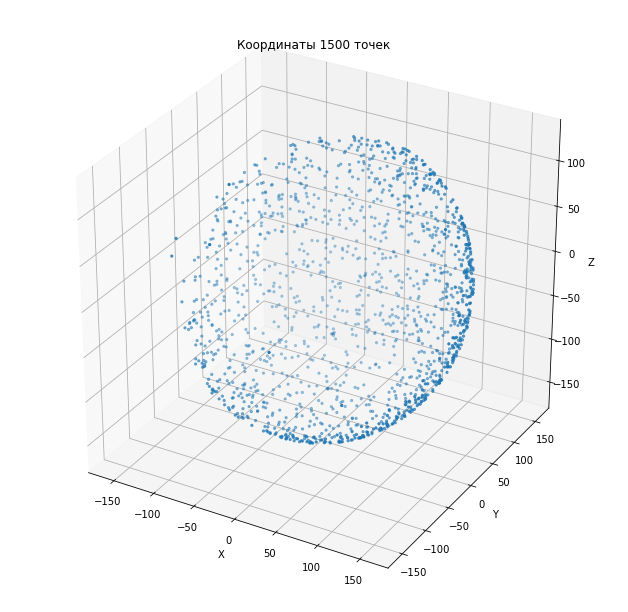

In [29]:
fig = plt.figure(figsize = (11, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[data["particle_name"]=="gamma"]["X"][:1500],
           data[data["particle_name"]=="gamma"]["Y"][:1500],
           data[data["particle_name"]=="gamma"]["Z"][:1500], marker=".")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Координаты 1500 точек')
plt.show()

### Поворот распределения для более удобной работы

In [102]:
xyz_e = data[data["particle_name"]=="gamma"]
xdata = xyz_e["X"].to_numpy()
ydata = xyz_e["Y"].to_numpy()
zdata = xyz_e["Z"].to_numpy()
edata = xyz_e["energy"].to_numpy()
xyz = np.array([xdata, ydata, zdata]).T

In [103]:
# Матрица поворота вокруг оси х
ang = -np.pi/4 # 45 градусов
Mx = [[1, 0, 0], [0, np.cos(ang), -np.sin(ang)], [0, np.sin(ang), np.cos(ang)]]

In [104]:
xyz = np.array([np.matmul(point, Mx) for point in xyz])

### Преобразование к полярным координатам

In [105]:
def cart2sph(n_xyz: np.array):
    r = np.sqrt(n_xyz[:, 0]**2 + n_xyz[:, 1]**2 + n_xyz[:, 2]**2)
    θ = np.arccos(n_xyz[:, 2]/r)
    φ = np.arctan2(n_xyz[:, 1], n_xyz[:, 0])
    return np.array([r, θ, φ]).T

def sph2cart(n_rθφ: np.array):
    n_rθφ[:, 2] = n_rθφ[:, 2] % (2*np.pi)
    n_rθφ[:, 1] = n_rθφ[:, 1] % (np.pi)
    x = n_rθφ[:, 0] * np.sin(n_rθφ[:, 1]) * np.cos(n_rθφ[:, 2])
    y = n_rθφ[:, 0] * np.sin(n_rθφ[:, 1]) * np.sin(n_rθφ[:, 2])
    z = n_rθφ[:, 0] * np.cos(n_rθφ[:, 1])
    return np.array([x, y, z]).T

In [38]:
nrθφ = cart2sph(xyz)

In [39]:
print(f"θ range: {min(nrθφ[:,1])} to {max(nrθφ[:,1])}")
print(f"φ range: {min(nrθφ[:,2])} to {max(nrθφ[:,2])}")

θ range: 0.0025852866083223717 to 3.1364349150117814
φ range: -3.1415115432908114 to 3.141495691776857


### Выбор интересующей области

In [40]:
θ_from = np.pi/2-np.pi/10
θ_to = np.pi/2+np.pi/10.

In [122]:
segment, out_segment = [], []
eseg = []
i = 0
j = 0
for i, dnrθφ in enumerate(nrθφ):
    r, theta, phi = dnrθφ
    if θ_from<theta and theta<θ_to:
        segment.append((1, theta, phi))
        eseg.append(edata[i])
        i += 1
    else:
        out_segment.append((1, theta, phi))
        j += 1
    
xyz_segment = sph2cart(np.array(segment))
xyz_out_segment = sph2cart(np.array(out_segment))

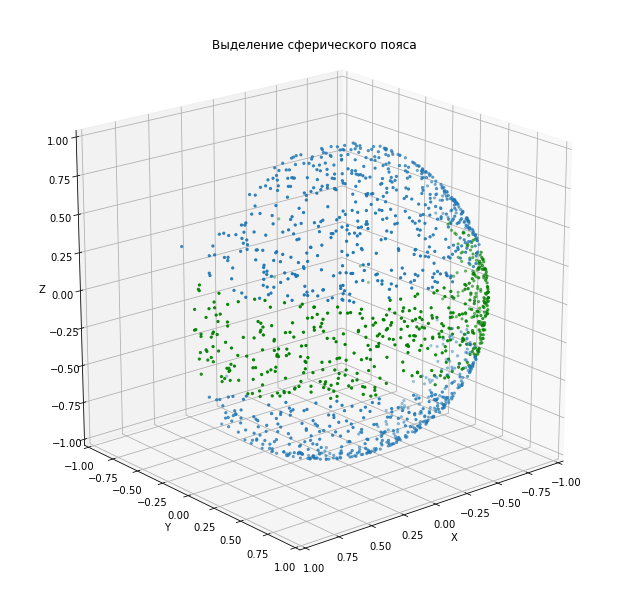

In [55]:
fig = plt.figure(figsize = (11, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*xyz_segment[:500].T, c="green", marker=".")
ax.scatter(*xyz_out_segment[:1000].T, marker=".")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_title('Выделение сферического пояса')
ax.view_init(elev=20, azim=50)
plt.show()

In [56]:
segment_theta = np.array(segment).T[2] # Select TPhi
hist = np.histogram(segment_theta, bins=100)
segment_theta.shape

(2291842,)

In [91]:
radii, theta = hist

In [92]:
adder = np.array([167,])

In [93]:
radii = np.concatenate((radii, adder))

In [94]:
# theta = hist[1][:100]
# radii = hist[0]

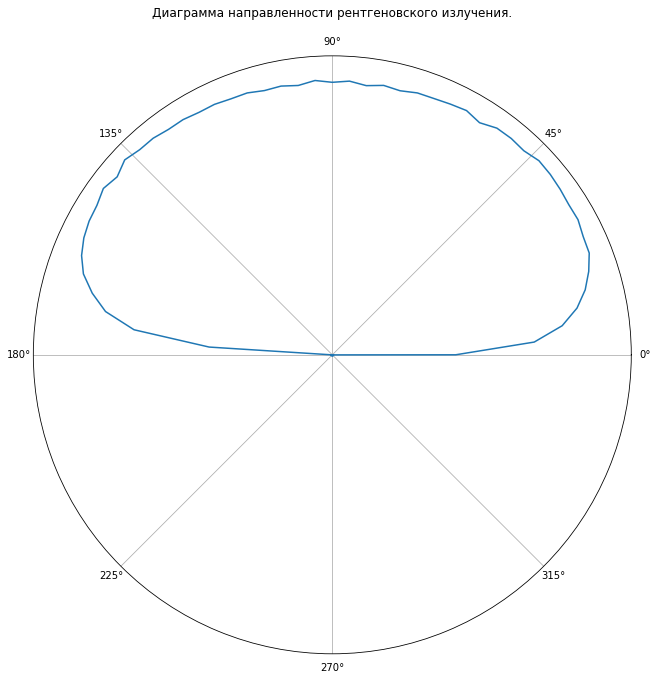

In [95]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (11, 11))

ax.plot(theta, radii)
ax.set_title("Диаграмма направленности рентгеновского излучения.", va='bottom')
ax.set_yticks([])
plt.show()

In [127]:
phi = np.array(segment).T[2]
eseg = np.array(eseg)

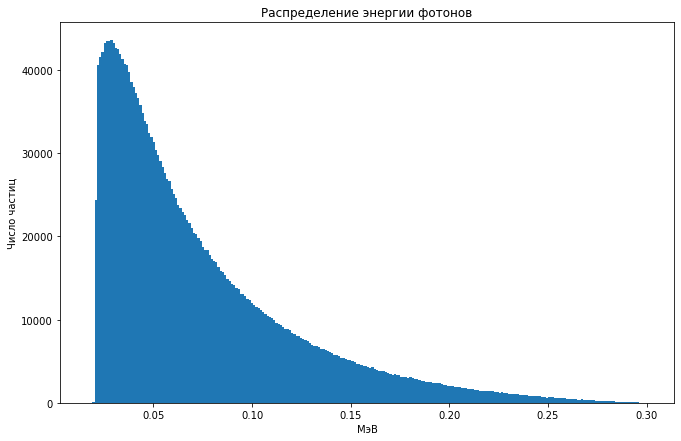

In [153]:
plt.figure(figsize=(11, 7))
plt.hist(eseg, bins =250)
plt.title('Распределение энергии фотонов')
plt.xlabel('МэВ')
plt.ylabel('Число частиц')
# plt.yticks([])
# plt.xticks(np.arange(0, 0.3, 10))
# plt.xticks(20)
plt.show()

### Диаграмма по шаровому поясу

In [96]:
xyz_e = data[data["particle_name"]=="gamma"]
xdata = xyz_e["X"].to_numpy()
ydata = xyz_e["Y"].to_numpy()
zdata = xyz_e["Z"].to_numpy()
endata = xyz_e["energy"].to_numpy()
xyz = np.array([xdata, ydata, zdata]).T

In [97]:
ang = -np.pi/2 # 45 градусов
def rotate(nxyz: np.array, axis: str, ang):
    assert nxyz.shape[1] == 3 # shape == (N, 3)
    Mx = [[1, 0, 0], [0, np.cos(ang), -np.sin(ang)], [0, np.sin(ang), np.cos(ang)]]
    My = [[np.cos(ang), 0, np.sin(ang)], [0, 1, 0], [-np.sin(ang), 0, np.cos(ang)]]
    Mz = [[np.cos(ang), -np.sin(ang), 0], [np.sin(ang), np.cos(ang), 0], [0, 0, 1]]
    M = {"X":Mx, "Y":My, "Z":Mz}
    return np.array([np.matmul(point, M[axis]) for point in nxyz])

In [98]:
xyz = rotate(xyz, "X", np.pi)

In [99]:
xyz.shape

(7384970, 3)

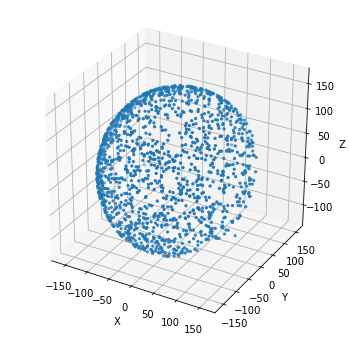

In [100]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[:1500,0],
           xyz[:1500,1],
           xyz[:1500,2], marker=".")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Подсчёт по кольцам

In [101]:
nrθφ = cart2sph(xyz)

In [76]:
segments = [], []
dθ = np.pi/12
for r, theta, phi in nrθφ:
    if θ_from<theta and theta<θ_to:
        segment.append((1, theta, phi))
    else:
        out_segment.append((1, theta, phi))

xyz_segment = sph2cart(np.array(segment))
xyz_out_segment = sph2cart(np.array(out_segment))